In [1]:
import warnings
from pathlib import Path
import json
import re
from multiprocessing import Pool

import numpy as np  
from scipy.optimize import minimize, OptimizeWarning, show_options

import emcee
from emcee.autocorr import AutocorrError
import corner

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import ufloat
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

from dust_extinction.parameter_averages import F99, F04, G23

from deblib.constants import M_sun, R_sun
from deblib.stellar import log_g

from libs import extinction
from libs.sed import get_sed_for_target, create_outliers_mask, group_and_average_fluxes
from libs.sed import calculate_vfv
from libs.pyssed import ModelSed

### Load the PySSED bt-settle model and set up the related model functions 

__Note:__ The data file is currently a copy of that kindly published on [GitHub](https://github.com/iain-mcdonald/PySSED)
by [McDonald at al., (2024)](https://ui.adsabs.harvard.edu/abs/2024RASTI...3...89M/abstract)

First we load the pre-built data of bt-settle synthetic SED which have previously been parsed
and saved with the `makemodel.py` module. The data file contains fluxes over a range of filters
for combinations of $T_{\rm eff}$, $\log{g}$, $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$. We build a
table in memory which holds a `RegularGridInterpolator` for each filter, with the dimensions/axes
being the $T_{\rm eff}$ and $\log{g}$ values and the values being the corresponding fluxes.

For now we consider only the data for solar metallicity, hence the interpolators only cover
$[{\rm Fe/H}] = 0$ and $[{\rm \alpha/Fe}] = 0$, however additional axes/dimensions
for $[{\rm Fe/H}]$ and $[{\rm \alpha/Fe}]$ may be added, if required.

In [2]:
# Read the pre-built bt-settl model file
model_sed = ModelSed("libs/data/pyssed/model-bt-settl-recast.dat")

print(f"Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:")
print(f"wavelength {model_sed.wavelength_range:unicode}, Teff {model_sed.teff_range:unicode}",
      f"and logg {model_sed.logg_range:unicode}")

Loaded previously built dataset of solar metallicity pyssed spectra covering the ranges:
wavelength [ 0.3 22. ] µm, Teff [ 1900. 70000.] K and logg [-0.5  6. ] dex


### Set up the extinction model

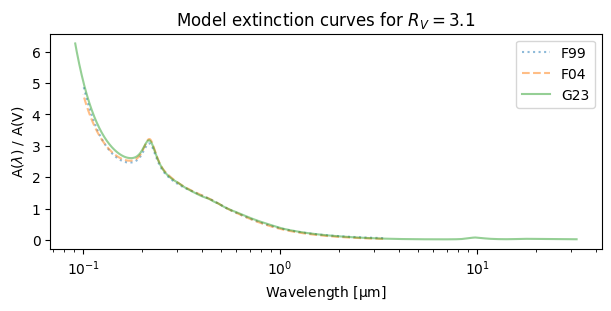

Using the G23 extinction model covers the range from 0.0912 µm to 32.0 µm.


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=f"Wavelength [{_lambda.unit:latex_inline}]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

### Select our target and get its known information

In [4]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(model_sed.teff_range).to(u.K).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

In [5]:
target = target_selection.value
target_config = targets_cfg[target]
target_label = target_config.get("label", target)
search_term = target_config.get("search_term", target)
target_config.setdefault("loggA", log_g(target_config["MA"] * M_sun, target_config["RA"] * R_sun).n)
target_config.setdefault("loggB", log_g(target_config["MB"] * M_sun, target_config["RB"] * R_sun).n)

# We need the coordinates and approximate distance for extinction lookups
simbad = Simbad()
simbad.add_votable_fields("parallax", "sp", "ids")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_ids = dict([i.rsplit(" ", 1) for i in _tbl["ids"][0].split("|")])
    target_spt = _tbl["sp_type"][0]
    
    print(f"{target} SkyCoords are {target_coords} (or {target_coords.to_string('hmsdms')})")
    print(f"AKA:", ", ".join(f"{k} {target_ids[k]}" for k in target_ids if k in ["TIC","Gaia DR3"]))
    print(f"SpT: {target_spt}")

CM Dra SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (248.58470944, 57.1623247, 14.86157925)> (or 16h34m20.33026606s +57d09m44.3689187s)
AKA: Gaia DR3 1431176943768690816, TIC 199574208
SpT: M4.5V


In [6]:
def teff_from_spt(target_spt):
    _map = { "M": ufloat(3100, 800), "K": ufloat(4600, 700), "G": ufloat(5650, 350), "F": ufloat(6700, 500),
            "A": ufloat(8600, 1300), "B": ufloat(20000, 10000), "O": ufloat(35000, 10000) }
    teff = None
    # Also add the whole spt in case it's just a single char (i.e.: V889 Aql is set to "A")
    if (spts := re.findall(r"([A-Z][0-9])", target_spt) + [target_spt.upper()]) is not None:
        for spt in spts:
            if (tp := spt.strip()[0]) in _map and _map[tp].n > (teff.n if teff is not None else 0):
                teff = _map[tp]
    return teff

teff_sys = teff_from_spt(target_spt) or ufloat(5700, 0)
logg_sys = ufloat(4.0, 0)

# Lookup the TESS Input Catalog (8.2) for starting "system" Teff and logg values
tic_catalog = Vizier(catalog="IV/39/tic82")
if _tbl := tic_catalog.query_object(search_term, radius=0.1 * u.arcsec):
    row = _tbl[0]["TIC" == target_ids["TIC"]]
    if row:
        # Teff may not be reliable - only use it if it's consistent with the SpT
        if teff_sys.n-teff_sys.s < (row["Teff"] or 0) < teff_sys.n+teff_sys.s:
            teff_sys = ufloat(row["Teff"], row.get("s_Teff", None) or 0)
        if (row["logg"] or 0) > 0:
            logg_sys = ufloat(row["logg"], row.get("s_logg", None) or 0)

# These will likely come out of light curve fitting with JKTEBOP - get from config for now
k = ufloat(target_config.get("k"), target_config.get("k_err", 0) or 0)
light_ratio = ufloat(10**(target_config.get("logLB", 1) - target_config.get("logLA", 1)), 0)
teff_ratio = (light_ratio / k**2)**0.25 # based on L = 4pi*R^2*Teff^4

print(f"{target} system values from lookup and LC fitting:")
for p, val, unit in [("teff_sys", teff_sys, u.K), ("logg_sys", logg_sys, u.dex),
            ("k", k, None), ("light_ratio", light_ratio, None), ("teff_ratio", teff_ratio, None)]:
    print(f"{p:>12s} = {val:.3f} {unit or u.dimensionless_unscaled:unicode}")

CM Dra system values from lookup and LC fitting:
    teff_sys = 3214.000+/-157.000 K
    logg_sys = 4.906+/-0.004 dex
           k = 0.945+/-0.001 
 light_ratio = 0.881+/-0 
  teff_ratio = 0.997+/-0.000 


Here we set the starting position for the fit, `theta0`, which is our 'best estimate' of the
$T_{\rm eff}$ and $\log{g}$ values for the system based on existing published data and the
light-curve fitting carried out previously.

In [7]:
_logg_sys_round = np.round(logg_sys.n * 10) / 10
if teff_ratio.n <= 1:
    theta0 = [round(teff_sys.n), round(teff_sys.n * teff_ratio.n), _logg_sys_round, _logg_sys_round]
else:
    theta0 = [round(teff_sys.n / teff_ratio.n), round(teff_sys.n), _logg_sys_round, _logg_sys_round]

theta_labels = [("TeffA", model_sed.teff_range.unit), ("TeffB", model_sed.teff_range.unit),
                ("loggA", model_sed.logg_range.unit), ("loggB", model_sed.logg_range.unit)]
print(f"For {target} we set the starting position (theta0) to be:",
    *(f"\n{l:>9s} = {theta0[ix]: .3f} {unit:unicode}" for ix, (l, unit) in enumerate(theta_labels)))

For CM Dra we set the starting position (theta0) to be: 
    TeffA =  3214.000 K 
    TeffB =  3203.000 K 
    loggA =  4.900 dex 
    loggB =  4.900 dex


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- remove duplicate SED measurements
- group and average SED measurements by filter & frequency
- exclude measurements outside the range of our extinction model
- exclude flux outliers

In [8]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Work in Jy rather than W/m^2/Hz as they are a more natural unit, giving values that minimize 
# potential FP rounding. Plots are agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True,
                         freq_unit=u.GHz, flux_unit=u.Jy, wl_unit=u.um)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= np.array([model_sed.has_filter(f) for f in sed["sed_filter"]])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_sed.wavelength_range)) & (sed["sed_wl"] <= max(model_sed.wavelength_range))
sed = sed[model_mask]

out_mask = np.zeros_like(model_mask[model_mask], dtype=bool)
#out_mask |= create_outliers_mask(sed, theta0[:2], min_unmasked=15, verbose=True)
sed = sed[~out_mask]
sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table cm-dra-0.1.vot containing 28 row(s).
Dropped 10 duplicate(s) leaving 18 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 12 group(s) from 18 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
11 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being Jy, GHz, µm


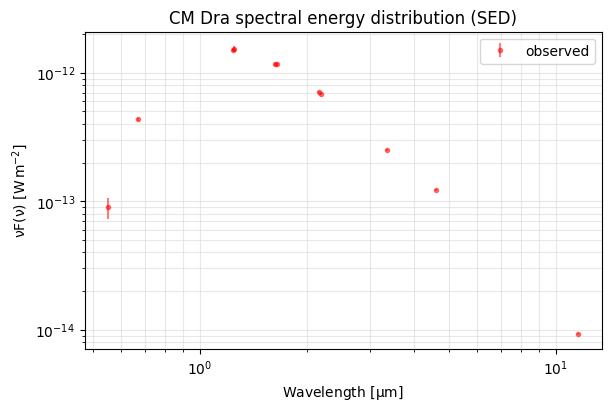

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, unit=u.W/u.m**2), fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target_label} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{u.um:latex_inline}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{u.W/u.m**2:latex_inline}]")
ax.grid(True, which="both", axis="both", alpha=0.5, color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED
Use the target coordinates to find an $E(B-V)$ value from the available extinction maps.
With this we can deredden the remaining SED fluxes using the previously created extinction model. 

In [10]:
for val, flags in extinction.get_ebv(target_coords, rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.237 s
  pix_info:   0.361 s
   samples:  14.267 s
      best:   2.764 s
       nan:   0.018 s
      sort:   7.755 s
       idx:   0.071 s
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
Found extinction with get_vergely_av: E(B-V) = 0.000515


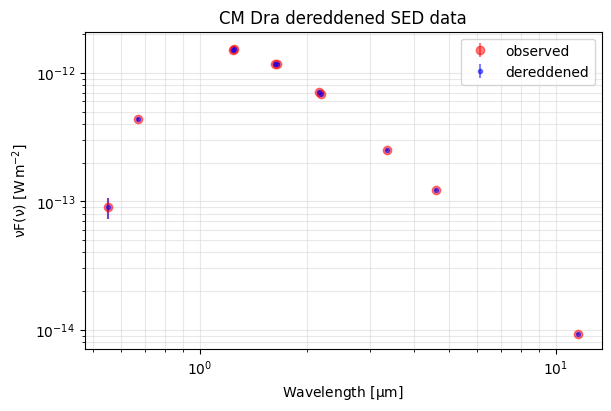

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, unit=u.W/u.m**2), fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"].to(u.um), *calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W/u.m**2), fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"{target_label} dereddened SED data",
       xscale="log", xlabel=f"Wavelength [{u.um:latex_inline}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{u.W/u.m**2:latex_inline}]")
ax.grid(True, which="both", axis="both", alpha=0.5, color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the functions which will support fitting

Here we set up the known priors and the **prior_func** which will be called during fitting
to return whether the current `theta` conforms to these criteria (returning 0), or not (np.inf).

In [12]:
# We can probably set some range based on SpT and evolutionary phase (ie: if k < 1 -> M-S)
MIN_TEFF, MAX_TEFF = model_sed.teff_range.to(u.K).value
MIN_LOGG = max(0.0, model_sed.logg_range.value.min())
MAX_LOGG = model_sed.logg_range.value.max()
print(f"Priors from synthetic data:\t{MIN_TEFF} < T_eff < {MAX_TEFF} [K] and {MIN_LOGG:.3f} < logg < {MAX_LOGG:.3f} [dex]")

# Target specific priors originating from LC fit
teff_flex = max(teff_ratio.n * 0.05, teff_ratio.s)
print(f"Priors from LC fitting:\t\tT_eff ratio={teff_ratio.n:.6f} +/- flex of {teff_flex:.6f}")

def prior_func(theta) -> float:
    if all(MIN_LOGG < l < MAX_LOGG for l in theta[2:]) \
        and all(MIN_TEFF < t < MAX_TEFF for t in theta[:2]) \
        and abs(theta[1]/theta[0] - teff_ratio.n) < teff_flex:
        return 0
    return np.inf

Priors from synthetic data:	1900.0 < T_eff < 70000.0 [K] and 0.000 < logg < 6.000 [dex]
Priors from LC fitting:		T_eff ratio=0.996630 +/- flex of 0.049832


The **model_func** will calculate a set of model SED flux data at points `x` for the current `theta`.
The implementation `scaled_summed_model(x, theta)` scales these model data to the known SED
fluxes before returning them.

In [13]:
# These are the functions for generating synthetic spectra and combining them into a model
flux_unit = sed["sed_der_flux"].unit
y_log = np.log10(sed["sed_der_flux"].quantity.value)

def scaled_summed_model(theta, x):
    teffA, teffB, loggA, loggB = theta
    # Scale the model to the obs' in log10 space as the range of potential values is very wide
    y_model_log = np.log10(np.add(
        model_sed.get_fluxes(x, teffA, loggA).value,
        model_sed.get_fluxes(x, teffB, loggB).value))
    if flux_unit != u.Jy and model_sed.flux_unit == u.Jy:
        y_model_log -= 26
    return 10**(y_model_log + np.median(y_log - y_model_log))

def weighted_chi_sq(y_model, y, w, degree_freedom=len(y_log)-len(theta0)) -> float:
    """ chi^2_w = 1/(N_obs-n_param) * Σ W(y-y_model)^2 """
    return np.sum(w * (y - y_model)**2) / degree_freedom

The **objective_func** (ln_prob_func in emcee "speak") is the function which will be optimized.
It pulls together `prior_func` to evaluate the current `theta` against the prior criteria and then
calculates and returns the $\chi^2_r$ value of the `scaled_summed_model` (based on `theta`) against
the observations.

**Note:** If `maximizable==True` the return values will be negated to support an emcee
`EnsembleSampler` which seeks to maximize this value. Otherwise the value will be positive which
supports scipy `minimize` optimization, which seeks to minimize the return values.

In [14]:
def objective_func(theta, x, y, w, maximizable: bool=False) -> float:
    """
    This is the function to be optimized to fit a model to the SED data

    :theta: the current set of parameters being fitted
    :x: the filters used for each of the observed fluxes
    :y: the observed fluxes
    :w: the weights to use for the weighted chi^2 evaluation
    :maximizable: whether this function is being minimized (False) or maximized by MCMC (True)
    :returns: a single value representing the likeness between the model and observations
    """
    if np.isfinite(retval := prior_func(theta)):
        retval += weighted_chi_sq(scaled_summed_model(theta, x), y, w)
        retval = np.nan_to_num(retval, nan=np.inf)
    return -retval if maximizable else retval

# Weights for chisq eval; with default of mod==1 we have 1/var, effectively giving us reduced chisq
_wt_mod = np.ones((len(sed)), dtype=float)
_wt = _wt_mod / sed["sed_eflux"].quantity.value**2
print(f"The fitting chisq weights are calculated as [", ", ".join(f"{m:.3f}" for m in _wt_mod),
      "] / sed_eflux^2\ngiving [", ", ".join(f"{w:.3e}" for w in _wt), "]")

# Everything after theta in the arg list is effectively fixed for each fitting - set them now
obj_args = ( # x, y, W
    model_sed.get_filter_indices(sed["sed_filter"]),
    sed["sed_der_flux"].quantity.value,
    _wt 
)

The fitting chisq weights are calculated as [ 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000 ] / sed_eflux^2
giving [ 1.041e+05, 2.150e+05, 6.944e+03, 9.406e+02, 4.444e+03, 4.444e+03, 1.000e+04, 1.000e+04, 2.778e+04, 1.111e+05, 4.000e+06 ]


### Run the initial "minimize" fit

In [15]:
with warnings.catch_warnings(category=[RuntimeWarning, OptimizeWarning]):
    warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
    warnings.filterwarnings("ignore", message="Desired error not necessarily achieved due to precision loss.")
    warnings.filterwarnings("ignore", message="Unknown solver options:")

    for method in [None, "Nelder-Mead", "SLSQP"]:
        soln = minimize(objective_func, x0=theta0, args=obj_args, method=method, options={ "maxiter": 5000, "maxfev": 5000 })
        print(f"minimize(method={method}) {'succeed' if soln.success else 'fail'}ed [{soln.message}]",
              f"after {soln.nit} iteration(s) & {soln.nfev} function evaluation(s) [fun = {soln.fun:.6f}]")
        # print(soln)
        if soln.success:
            break

    theta_fit_min = soln.x

minimize(method=None) failed [Desired error not necessarily achieved due to precision loss.] after 1 iteration(s) & 84 function evaluation(s) [fun = 9.873397]
minimize(method=Nelder-Mead) succeeded [Optimization terminated successfully.] after 465 iteration(s) & 791 function evaluation(s) [fun = 7.334351]


In [16]:
def plot_fitted_model(theta):
    teffA, teffB, loggA, loggB = theta
    filter_ixs = model_sed.get_filter_indices(sed["sed_filter"])
    flux_unit = sed["sed_der_flux"].unit
    sed_wl = sed["sed_wl"].to(u.um)
    
    # The baseline dereddened observed SED data in nu*F(nu) form
    obs_der_vfv, obs_der_evfv = calculate_vfv(sed, flux_colname="sed_der_flux", unit=u.W / u.m**2)

    # Generate a model SED from the fitted values in nu*F(nu) form for plotting
    raw_mod_fluxes = np.array([model_sed.get_fluxes(filter_ixs, teffA, loggA).value,
                               model_sed.get_fluxes(filter_ixs, teffB, loggB).value])
    flux_ratio_A = raw_mod_fluxes[0] / np.add(*raw_mod_fluxes)
    mod_comb_vfv = (scaled_summed_model(theta, filter_ixs) * flux_unit * sed["sed_freq"].quantity).to(obs_der_vfv.unit)
    mod_starA_vfv = mod_comb_vfv * flux_ratio_A
    mod_starB_vfv = mod_comb_vfv * (1 - flux_ratio_A)

    # Plot the fitted model against the derredened SED + show each star's contribution
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
    for (lam,       flux,               eflux,              fmt,    alpha,  z,      label) in [
        (sed_wl,    obs_der_vfv,        obs_der_evfv,       "ob",   0.5,    50,     "dereddened SED"),
        (sed_wl,    mod_comb_vfv,       None,               ".k",   0.66,   90,     "fitted pair"),
        (sed_wl,    mod_starA_vfv,      None,               "*g",   0.66,   80,     "fitted star A"),
        (sed_wl,    mod_starB_vfv,      None,               "xr",   0.66,   70,     "fitted star B"),
    ]:
        ax.errorbar(lam, flux, eflux, fmt=fmt, alpha=alpha, zorder=z, label=label)
    ax.set(title=f"{target_label} dereddened SED and fitted model", xscale="log", yscale="log",
           xlabel=f"Wavelength [{sed_wl.unit:latex_inline}]",
           ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{obs_der_vfv.unit:latex_inline}]")
    ax.grid(True, which="both", axis="both", color="lightgray", alpha=0.5, zorder=0)
    ax.legend(loc="best")
    plt.show(fig)
    plt.close(fig)

Best fit parameters for CM Dra from minimization fit
    TeffA =  3200.000 K (known value 3130.000+/-70.000)
    TeffB =  3145.881 K (known value 3120.000+/-70.000)
    loggA =  6.000 dex (known value 4.994+/-0)
    loggB =  5.854 dex (known value 5.010+/-0)


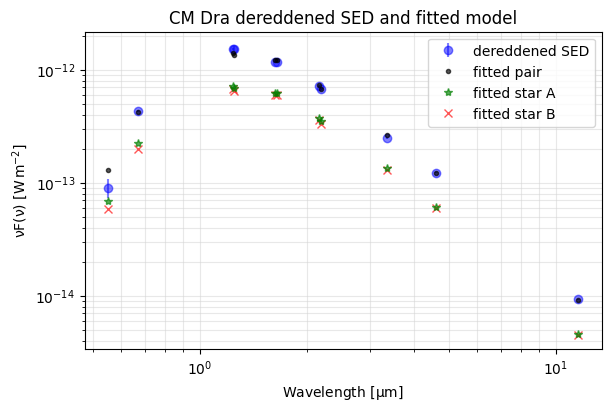

In [17]:
print(f"Best fit parameters for {target} from minimization fit")
for ix, (l, unit) in enumerate(theta_labels):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>9s} = {theta_fit_min[ix]: .3f} {unit:unicode} (known value {known_val:.3f})")    

plot_fitted_model(theta_fit_min)

### Perform MCMC fitting for more reliable fit with a probability distribution
Using the output of the "quick" minimize fit as the input.

In [18]:
init_sigma = np.array([1000, 1000, 1, 1]) * 0.05
nwalkers, niters = 100, 100000

rng = np.random.default_rng(42)
ndim = theta_fit_min.shape[0]
p0 = [theta_fit_min + rng.normal(0, init_sigma) for _ in range(int(nwalkers))]

with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for up to {niters:,} iterations with {nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_func,
                                        args=obj_args, kwargs={ "maximizable": True }, pool=pool)

        prev_tau = np.inf
        for sample in sampler.sample(initial_state=p0, iterations=niters, progress=True):
            if sampler.iteration % 1000 == 0:
                # autocorrelation time; steps to effectively "forget" start position
                tau = sampler.get_autocorr_time(tol=0)
                if all(tau < sampler.iteration / 100) and all(abs(prev_tau - tau) / tau < 0.01):
                    print(f"Halting the MCMC after {sampler.iteration:,} iterations as we've",
                           "passed 100 times the autocorrelation time and the fit has converged.")
                    break
                prev_tau = tau

Running MCMC for up to 100,000 iterations with 100 walkers.


 13%|█▎        | 13000/100000 [06:54<46:14, 31.35it/s]  

Halting the MCMC after 13,000 iterations as we've passed 100 times the autocorrelation time and the fit has converged.


In [19]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction:    {accept_frac:.6f}")

try:
    tau = sampler.get_autocorr_time(c=1)
    print(f"Autocorrelation steps (tau):", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
print(f"Approximate burn-in steps:   {burn_in_steps:,}")

Mean Acceptance fraction:    0.433055
Autocorrelation steps (tau): 69.560, 69.671, 79.969, 79.703
Approximate burn-in steps:   159


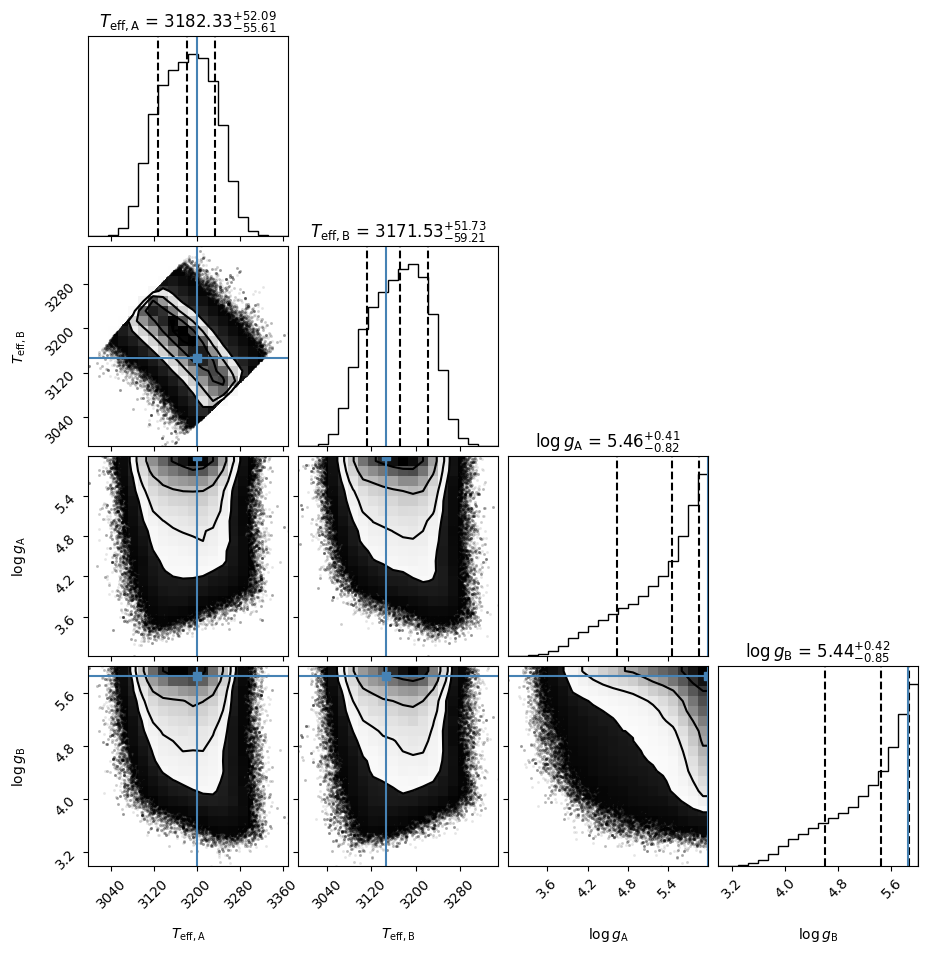

In [20]:
# thin; every nth step from the chain
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))
samples = sampler.get_chain(discard=burn_in_steps, thin=thin, flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=[r"$T_{\rm eff,A}$", r"$T_{\rm eff,B}$", r"$\log{g}_{\rm A}$", r"$\log{g}_{\rm B}$"],
                    truths=theta_fit_min)
plt.show(fig)
plt.close(fig)

Best fit parameters for CM Dra from subsequent MCMC fit
    TeffA = 3182.330 +/- 52.091/55.609 K (known value 3130.000+/-70.000 K)
    TeffB = 3171.529 +/- 51.731/59.205 K (known value 3120.000+/-70.000 K)
    loggA = 5.461 +/- 0.405/0.816 dex (known value 4.994+/-0 dex)
    loggB = 5.442 +/- 0.421/0.851 dex (known value 5.010+/-0 dex)


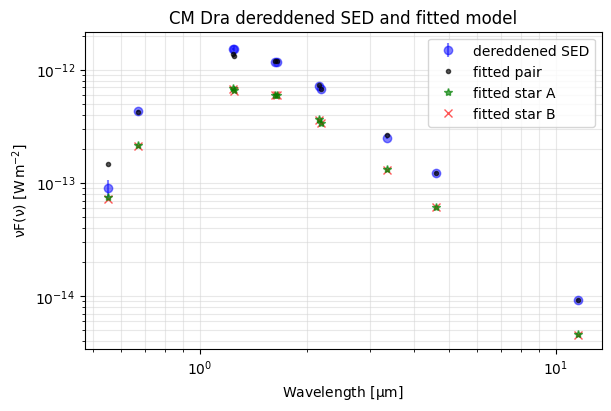

In [21]:
# Gets the median fitted values (currently M1, M2 and log(age))
theta_fit_mcmc = np.median(samples[burn_in_steps:], axis=0)
fitted_high = np.quantile(samples[burn_in_steps:], 0.84, axis=0) - theta_fit_mcmc
fitted_low = theta_fit_mcmc - np.quantile(samples[burn_in_steps:], 0.16, axis=0)

print(f"Best fit parameters for {target} from subsequent MCMC fit")
for ix, (l, unit) in enumerate(theta_labels):
    known_val = ufloat(target_config.get(l, np.NaN), target_config.get(l + "_err", None) or 0)
    print(f"{l:>9s} = {theta_fit_mcmc[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f}",
          f"{unit:unicode} (known value {known_val:.3f} {unit:unicode})") 

plot_fitted_model(theta_fit_mcmc)